<a href="https://colab.research.google.com/github/katL7/GTSRB-APS360/blob/SVM_decisionTree/project_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download triffic sign data
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from google.colab import drive
import os
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize, downscale_local_mean

import pandas as pd
import seaborn as sns
%matplotlib inline
# # Importing Data file
# data = pd.read_csv('bc2.csv')
# dataset = pd.DataFrame(data)
# dataset.columns

# Import data

In [ ]:
gtsrb_data = datasets.GTSRB('data', download=True)
gtsrb_rotated = datasets.GTSRB('data', download=True, 
                           transform=transforms.RandomRotation(25))

  0%|          | 0/187490228 [00:00<?, ?it/s]

Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


Figuring out the structure of the dataset

## Labels

In [ ]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualisation

In [ ]:
print("Len of one item of the data set", len(gtsrb_data[100]))

Len of one item of the data set 2


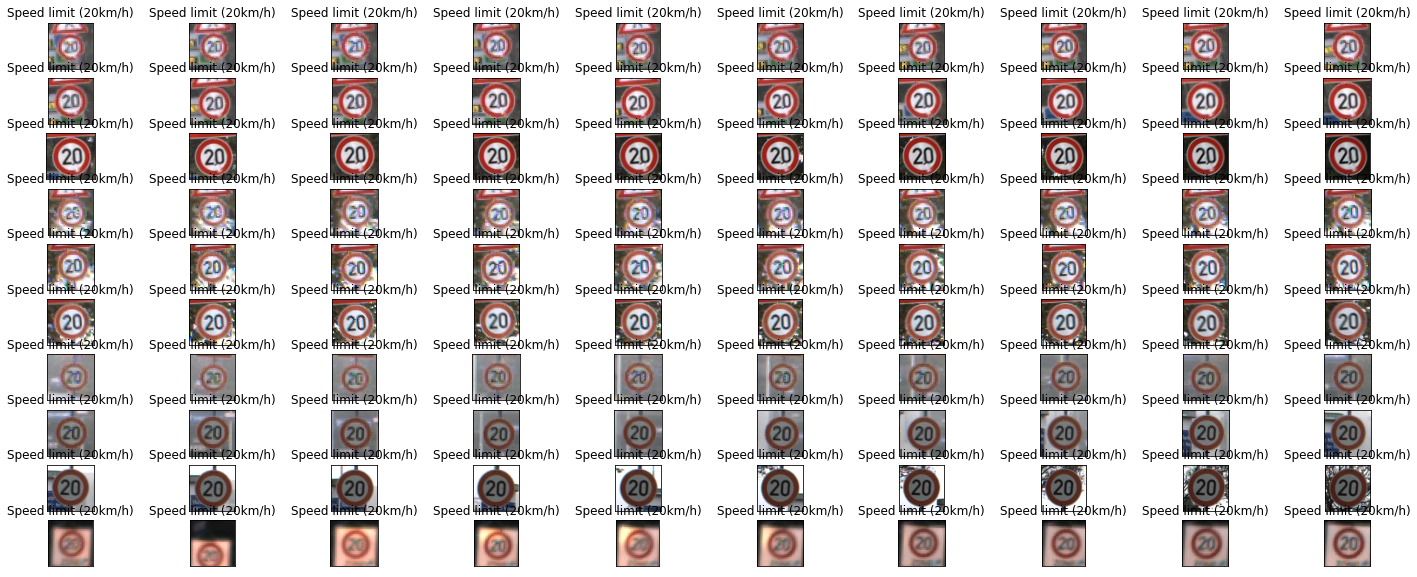

In [ ]:
# plot the images with the corresponding labels

fig = plt.figure(figsize=(25, 10))
for idx in np.arange(100):
    ax = fig.add_subplot(10, 20/2, idx+1, xticks=[], yticks=[])

    plt.imshow(gtsrb_data[idx][0])
    ax.set_title(classes[gtsrb_data[idx][1]])

plt.show()

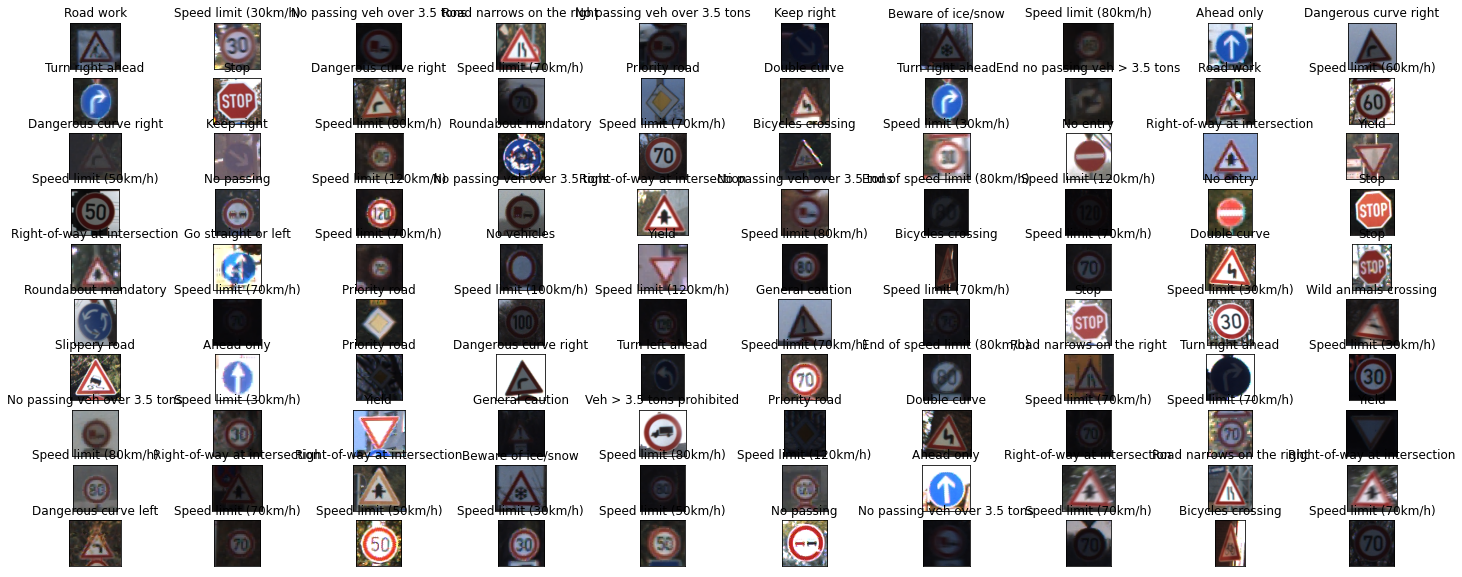

In [ ]:
# plot the images with the corresponding labels
indices = np.random.randint(0, len(gtsrb_data), 100)

fig = plt.figure(figsize=(25, 10))
for idx in np.arange(100):
    ax = fig.add_subplot(10, 20/2, idx+1, xticks=[], yticks=[])

    plt.imshow(gtsrb_data[indices[idx]][0])
    ax.set_title(classes[gtsrb_data[indices[idx]][1]])

plt.show()

In [ ]:
gtsrb_data.extra_repr

<bound method VisionDataset.extra_repr of Dataset GTSRB
    Number of datapoints: 26640
    Root location: data>

In [ ]:
ls_id = []
ls_classes = []
ls_height = []
ls_width = []
ls_images = []


for i in range(len(gtsrb_data)):
  ls_id.append(i)
  img, l = gtsrb_data[i]
  ls_classes.append(l)
  ls_height.append(img.size[0])
  ls_width.append(img.size[1])
  ls_images.append(np.array(img))



In [ ]:
pd_gtsrb = pd.DataFrame(np.array([ls_id, ls_classes, ls_height, ls_width]).T,
                   columns=['ID', 'Classe Nb', 'Height', 'Width'])

pd_gtsrb.head(10)

,ID,Classe Nb,Height,Width
0,0,0,29,30
1,1,0,30,30
2,2,0,30,30
3,3,0,31,31
4,4,0,30,32
5,5,0,31,31
6,6,0,33,34
7,7,0,34,35
8,8,0,33,34
9,9,0,36,36


In [ ]:
pd_gtsrb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26640 entries, 0 to 26639
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         26640 non-null  int64
 1   Classe Nb  26640 non-null  int64
 2   Height     26640 non-null  int64
 3   Width      26640 non-null  int64
dtypes: int64(4)
memory usage: 832.6 KB


In [ ]:
pd_gtsrb[['Classe Nb',	'Height',	'Width']].describe()

,Classe Nb,Height,Width
count,26640.000000,26640.000000,26640.000000
mean,15.887387,50.933784,50.365128
std,12.044099,24.373418,23.161523
min,0.000000,25.000000,25.000000
25%,5.000000,35.000000,35.000000
50%,12.000000,43.000000,43.000000
75%,25.000000,58.000000,58.000000
max,42.000000,243.000000,225.000000


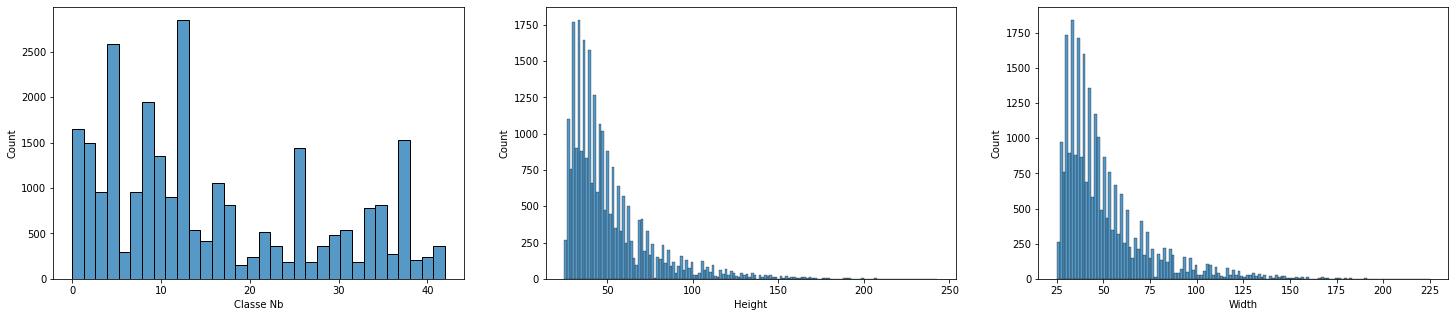

In [ ]:
plt.figure(figsize = (25, 5))
plt.subplot(131)
sns.histplot(data=pd_gtsrb, x="Classe Nb")
plt.subplot(132)
sns.histplot(data=pd_gtsrb, x="Height")
plt.subplot(133)
sns.histplot(data=pd_gtsrb, x="Width")
plt.show()

# Building train validation and test set

Resize all images to the max size

In [ ]:
resized_gtsrb[:,1][0].shape

(25, 25, 3)

In [ ]:
np_gtsrb = np.array([ls_id, ls_images, ls_classes, ls_height, ls_width]).T

min_hw = np.min(np.array(pd_gtsrb[['Height',	'Width']]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
resized_gtsrb = np_gtsrb

for i in range (resized_gtsrb.shape[0]):

  resized_gtsrb[i,1] = resize(resized_gtsrb[i,1], (min_hw, min_hw),
                       anti_aliasing=True).reshape(-)

# SVM definition

In [ ]:
resized_gtsrb[2,1].shape

(25, 25, 3)

In [ ]:
features = resized_gtsrb[:,1].reshape(resized_gtsrb.shape[0], min_hw * min_hw * 3).shape

ValueError: ignored

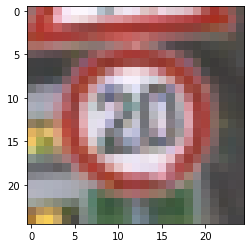

In [ ]:
plt.imshow(np_gtsrb[10,1])

In [ ]:
np_gtsrb[0,1].shape

(25, 25, 3)

In [ ]:
from sklearn.model_selection import train_test_split
 
# To calculate the accuracy score of the model
from sklearn.metrics import accuracy_score, confusion_matrix
 
target = resized_gtsrb[:,2]
features = resized_gtsrb[:,1].reshape(, 12288)
X_train, X_test, y_train, y_test = train_test_split(features,target, test_size = 0.1, random_state = 10)
from sklearn.svm import SVC
 
# Building a Support Vector Machine on train data
svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
 
prediction = svc_model .predict(X_test)
# check the accuracy on the training set
print(svc_model.score(X_train, y_train))
print(svc_model.score(X_test, y_test))

ValueError: ignored

# Test

In [ ]:
url=input('Enter URL of Image :')
img=imread(url)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=model.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[model.predict(l)[0]])